In [1]:
import pandas as pd

## **Lire et préparation des données**

In [2]:
df = pd.read_csv("https://query.data.world/s/gl4ldmqj3t5h25s5f6lhgsj6kfkfr6?dws=00000", parse_dates={"date":["YEAR", "MONTH"]})
df["date"] = df["date"].dt.to_period("M")   # On a pas d'informations sur le jour et l'heure, seulement sur l'année et le mois

In [3]:
df.head()

,date,Sum_PASSENGERS,AIRLINE_ID,CARRIER_NAME,ORIGIN,ORIGIN_CITY_NAME,ORIGIN_STATE_ABR,ORIGIN_STATE_NM,ORIGIN_COUNTRY,ORIGIN_COUNTRY_NAME,DEST,DEST_CITY_NAME,DEST_STATE_ABR,DEST_STATE_NM,DEST_COUNTRY,DEST_COUNTRY_NAME
0,2015-03,0,NaN,NaN,AEX,"Alexandria, LA",LA,Louisiana,US,United States,AEX,"Alexandria, LA",LA,Louisiana,US,United States
1,2015-04,0,NaN,NaN,AEX,"Alexandria, LA",LA,Louisiana,US,United States,AFW,"Dallas/Fort Worth, TX",TX,Texas,US,United States
2,2015-03,0,NaN,NaN,AEX,"Alexandria, LA",LA,Louisiana,US,United States,ATL,"Atlanta, GA",GA,Georgia,US,United States
3,2015-01,89,NaN,NaN,AEX,"Alexandria, LA",LA,Louisiana,US,United States,BOG,"Bogota, Colombia",NaN,NaN,CO,Colombia
4,2015-03,108,NaN,NaN,AEX,"Alexandria, LA",LA,Louisiana,US,United States,BOG,"Bogota, Colombia",NaN,NaN,CO,Colombia


In [4]:
df[df["DEST_COUNTRY"]=="GA"]

,date,Sum_PASSENGERS,AIRLINE_ID,CARRIER_NAME,ORIGIN,ORIGIN_CITY_NAME,ORIGIN_STATE_ABR,ORIGIN_STATE_NM,ORIGIN_COUNTRY,ORIGIN_COUNTRY_NAME,DEST,DEST_CITY_NAME,DEST_STATE_ABR,DEST_STATE_NM,DEST_COUNTRY,DEST_COUNTRY_NAME
2629643,2001-11,0,20100.0,Polar Air Cargo Airways,JFK,"New York, NY",NY,New York,US,United States,LBV,"Libreville, Gabon",NaN,NaN,GA,Gabon
2884093,2017-06,0,20110.0,Antonov Company,SBD,"San Bernardino, CA",CA,California,US,United States,LBV,"Libreville, Gabon",NaN,NaN,GA,Gabon
3017534,2009-03,0,20190.0,Southern Air Inc.,ATL,"Atlanta, GA",GA,Georgia,US,United States,LBV,"Libreville, Gabon",NaN,NaN,GA,Gabon
3586633,2005-10,0,20308.0,Centurion Cargo Inc.,MIA,"Miami, FL",FL,Florida,US,United States,LBV,"Libreville, Gabon",NaN,NaN,GA,Gabon
5585680,2008-08,0,20428.0,Volga-Dnepr Airlines,IAH,"Houston, TX",TX,Texas,US,United States,LBV,"Libreville, Gabon",NaN,NaN,GA,Gabon
5585681,2012-11,0,20428.0,Volga-Dnepr Airlines,IAH,"Houston, TX",TX,Texas,US,United States,LBV,"Libreville, Gabon",NaN,NaN,GA,Gabon
5585972,2005-10,0,20428.0,Volga-Dnepr Airlines,LAX,"Los Angeles, CA",CA,California,US,United States,LBV,"Libreville, Gabon",NaN,NaN,GA,Gabon


<AxesSubplot:title={'center':'Nombre de passagers mensuel ayant pour destination FR'}, xlabel='Date (mois et année)', ylabel='Nombre de passagers'>

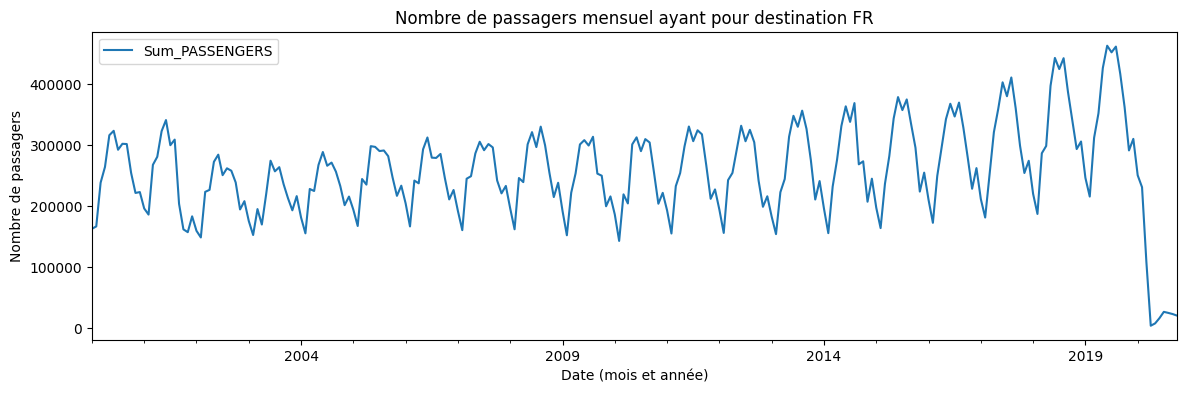

In [5]:
# Nombre de passagers allant dans un pays chaque mois
country_code = "FR"
data = df[df["DEST_COUNTRY"]==country_code][["date", "Sum_PASSENGERS"]].groupby("date").sum()
data.plot(title=f"Nombre de passagers mensuel ayant pour destination {country_code}",
          xlabel="Date (mois et année)",
          ylabel="Nombre de passagers",
          figsize=(14,4))

## **Décomposition STL**

In [6]:
from statsmodels.tsa.seasonal import STL
import matplotlib.pyplot as plt
import numpy as np

In [7]:
nb_passengers = data["Sum_PASSENGERS"].values

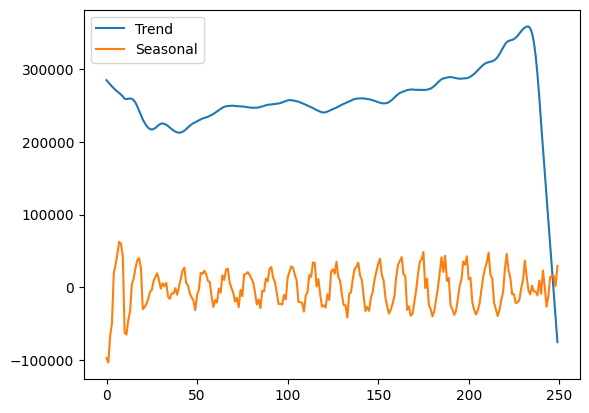

In [31]:
stl = STL(nb_passengers, period=10)
result = stl.fit()
plt.plot(result.trend, label="Trend")
plt.plot(result.seasonal, label="Seasonal")
plt.legend()

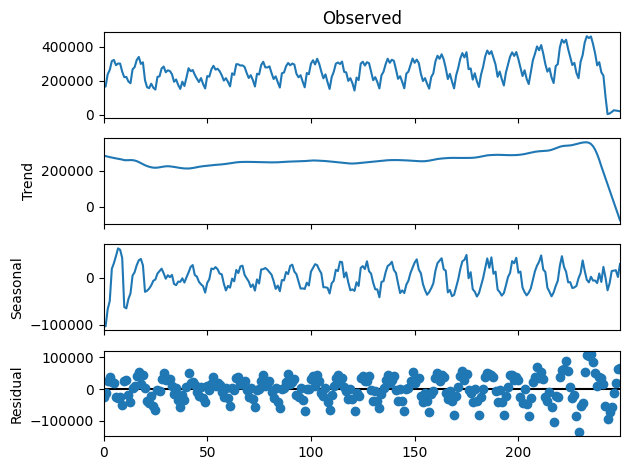

In [32]:
result.plot()
plt.show()

## **Prédictions naïves**

In [13]:
from sktime.forecasting.naive import NaiveForecaster
from sktime.performance_metrics.forecasting import mean_absolute_percentage_error as smape_loss
from sktime.utils.plotting import plot_series
from sktime.forecasting.model_selection import temporal_train_test_split

In [16]:
def plot_ys(*args, **kwargs):
        # restore 2020 behaviour (jfb) --> plot_ys supprimé
        nb_series=len(args)
        plot_series(*args, **kwargs, markers=['' for k in range(nb_series)])

In [24]:
y_train, y_test = temporal_train_test_split(nb_passengers, test_size=30)
y_train = pd.Series(y_train)
y_test = pd.Series(y_test)

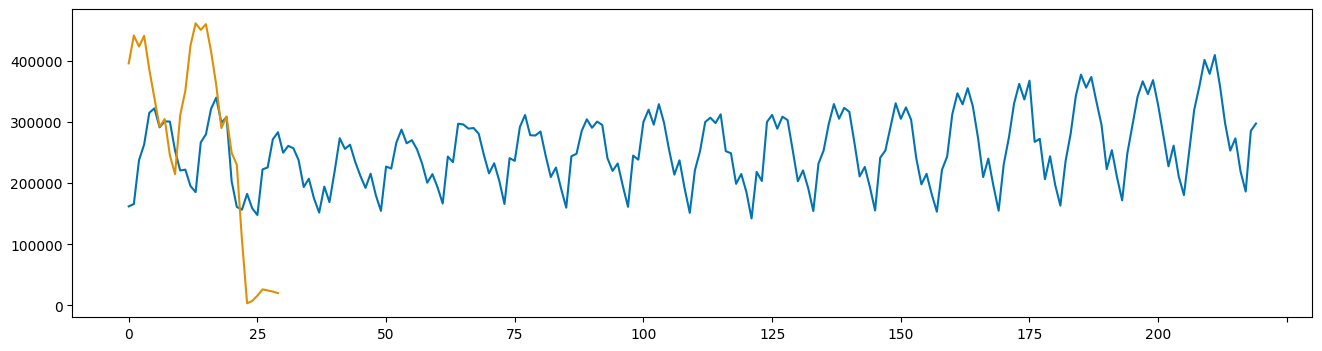

In [25]:
plot_ys(y_train, y_test)

SMAPE_LOSS: 6.638233162761259


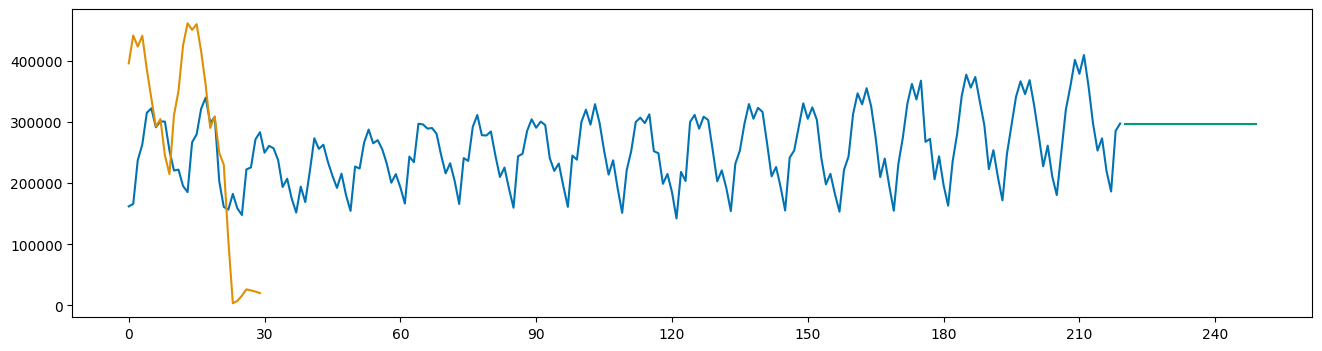

In [40]:
fh = np.arange(1,len(y_test)+1) 

forecaster = NaiveForecaster(strategy='last')
forecaster.fit(y_train)
y_pred = forecaster.predict(fh)
plot_ys(y_train, y_test, y_pred)
print(f"SMAPE_LOSS: {smape_loss(y_test, y_pred)}")

SMAPE_LOSS: 6.189660914954509


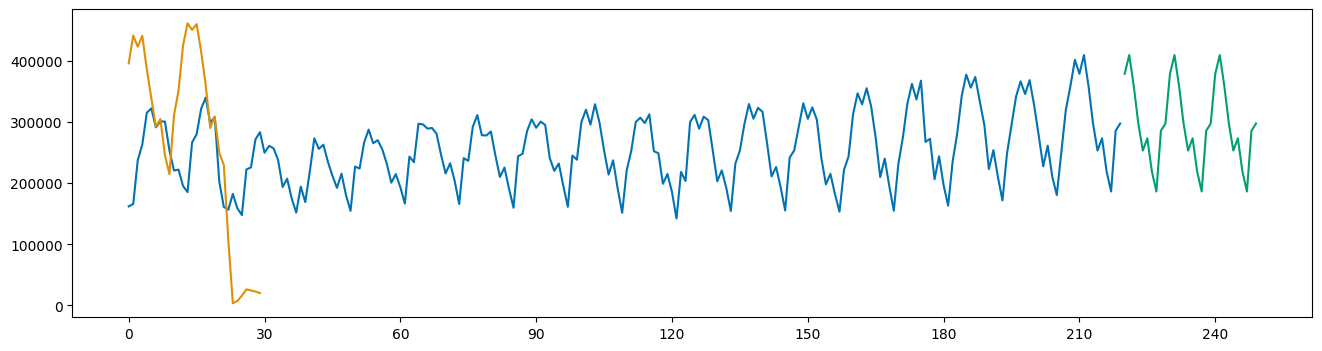

In [41]:
forecaster = NaiveForecaster(strategy='last', sp=10)
forecaster.fit(y_train)
y_pred = forecaster.predict(fh)
plot_ys(y_train, y_test, y_pred)
print(f"SMAPE_LOSS: {smape_loss(y_test, y_pred)}")

## **Prédictions**

In [42]:
from sktime.forecasting.compose import make_reduction
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor

SMAPE_LOSS: 7.089318511684448


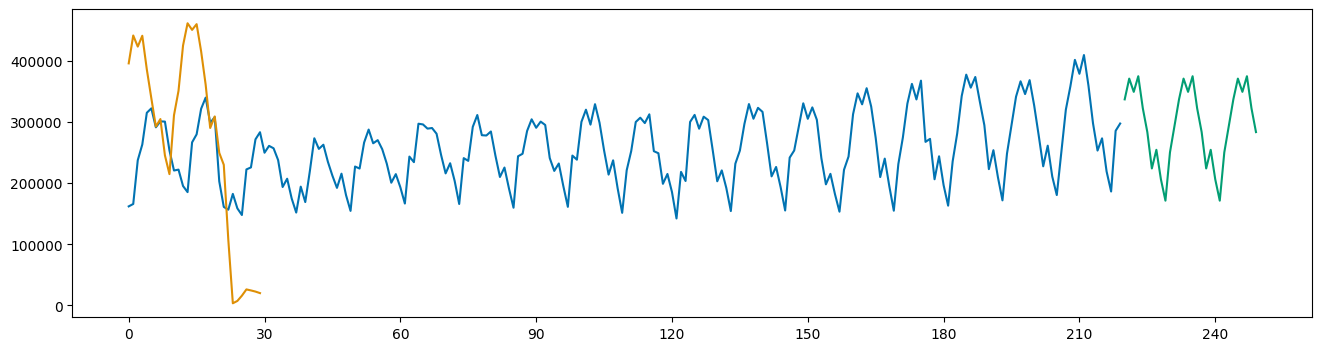

In [43]:
regressor = KNeighborsRegressor()
forecaster = make_reduction(regressor, strategy="recursive", window_length=100)
forecaster.fit(y_train)
y_pred = forecaster.predict(fh)
plot_ys(y_train, y_test, y_pred)
print(f"SMAPE_LOSS: {smape_loss(y_test, y_pred)}")

SMAPE_LOSS: 7.599234066920341


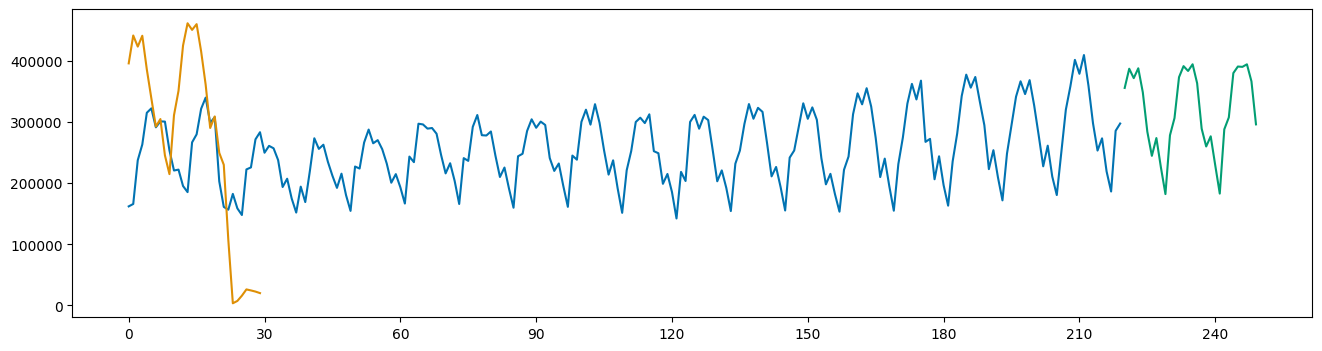

In [44]:
regressor = RandomForestRegressor()
forecaster = make_reduction(regressor, strategy="recursive", window_length=100)
forecaster.fit(y_train)
y_pred = forecaster.predict(fh)
plot_ys(y_train, y_test, y_pred)
print(f"SMAPE_LOSS: {smape_loss(y_test, y_pred)}")

c:\Users\sofi1\miniconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


SMAPE_LOSS: 5.491956969747561


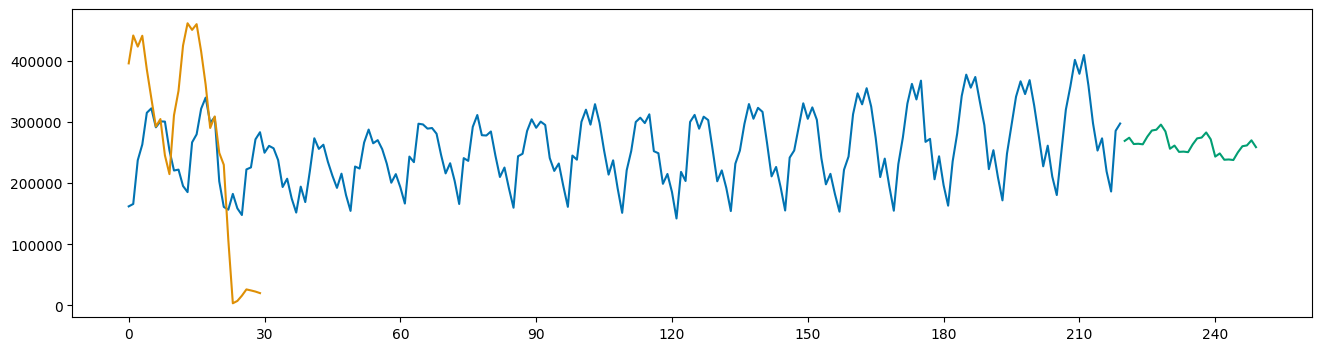

In [45]:
from sktime.forecasting.exp_smoothing import ExponentialSmoothing

from sktime.forecasting.exp_smoothing import ExponentialSmoothing
forecaster = ExponentialSmoothing(trend="add", seasonal="additive", 
                                  sp=10)
forecaster.fit(y_train)
y_pred = forecaster.predict(fh)
plot_ys(y_train, y_test, y_pred)
print(f"SMAPE_LOSS: {smape_loss(y_test, y_pred)}")